In [ ]:
pip install umap-learn

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

import umap

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS


import random
import time

std_figure_size = (8,5)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

fixed_random_state = random.seed(42)
n_parallel_jobs = -1

%config IPCompleter.use_jedi=False

In [ ]:
df_iris = sns.load_dataset('iris')
df_iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [ ]:
n_dup = len(df_iris) - len(df_iris.drop_duplicates())

print(f"Number of duplicate rows: {n_dup}")

Number of duplicate rows: 1


In [ ]:
df_iris.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [ ]:
df_iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [ ]:
cols_cleaned = []

for col in df_iris.columns:
    cols_cleaned.append(col.strip().lower())

df_iris.columns = cols_cleaned

# sanity check
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


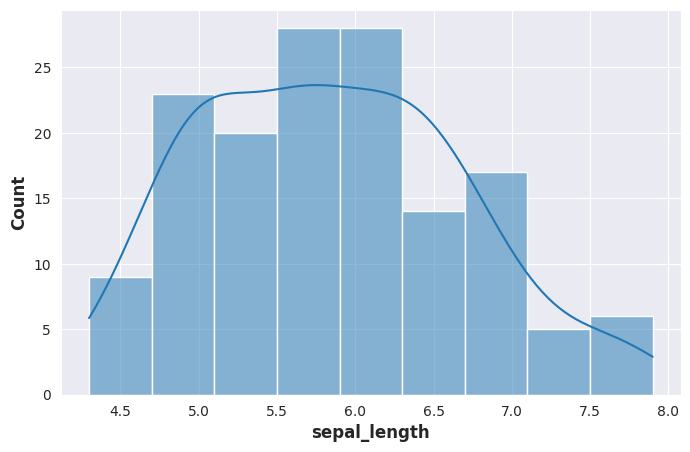

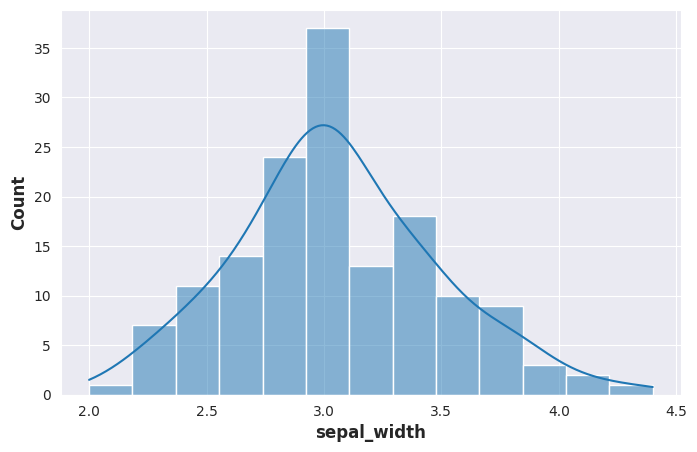

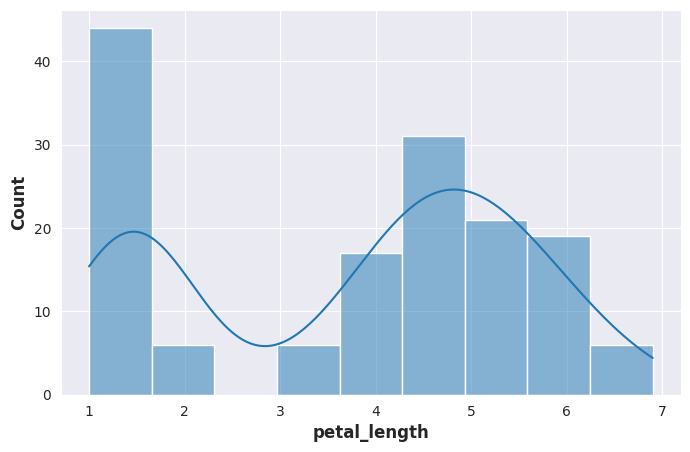

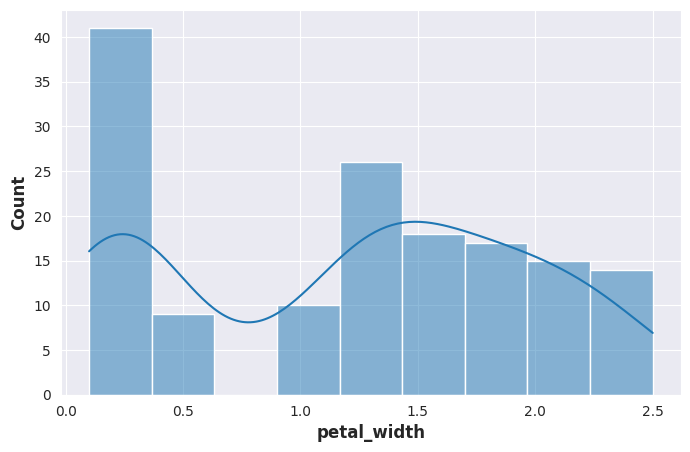

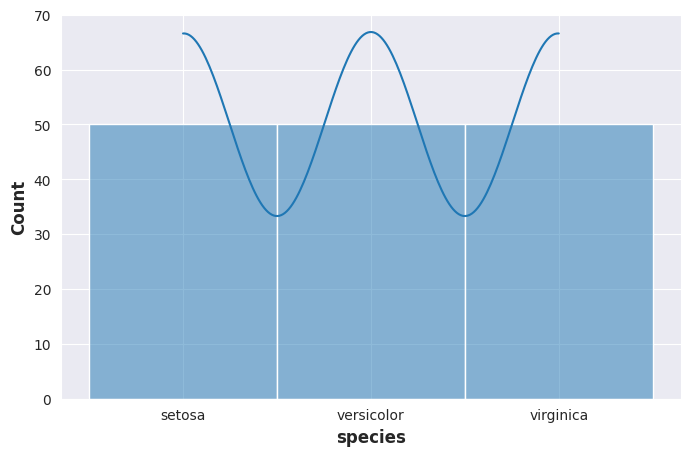

In [ ]:
for col in df_iris.columns:
    fig, axs = plt.subplots(figsize=std_figure_size)
    sns.histplot(data=df_iris, x=col, kde=True, ax=axs)
    plt.show()

# Clustering

In [ ]:
algoritmos = ["K-means", "Mean shift", "Gaussian mixtures", "Affinity propagation", "DBSCAN", "OPTICS"]

# saving training times for each algo
training_times = []

## Scaling and Standardizing

In [ ]:
data = df_iris.iloc[:,[0,1,2,3]]
target = df_iris['species']

data,target

(     sepal_length  sepal_width  petal_length  petal_width
 0             5.1          3.5           1.4          0.2
 1             4.9          3.0           1.4          0.2
 2             4.7          3.2           1.3          0.2
 3             4.6          3.1           1.5          0.2
 4             5.0          3.6           1.4          0.2
 ..            ...          ...           ...          ...
 145           6.7          3.0           5.2          2.3
 146           6.3          2.5           5.0          1.9
 147           6.5          3.0           5.2          2.0
 148           6.2          3.4           5.4          2.3
 149           5.9          3.0           5.1          1.8
 
 [150 rows x 4 columns],
 0         setosa
 1         setosa
 2         setosa
 3         setosa
 4         setosa
          ...    
 145    virginica
 146    virginica
 147    virginica
 148    virginica
 149    virginica
 Name: species, Length: 150, dtype: object)

In [ ]:
X = StandardScaler().fit_transform(data)

In [ ]:
X = PowerTransformer(standardize=False).fit_transform(X)

In [ ]:
X = pd.DataFrame(X, columns=data.columns)

# sanity check
X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,-0.972914,0.953811,-1.120641,-1.222596
1,-1.254819,-0.133410,-1.120641,-1.222596
2,-1.543675,0.320242,-1.161675,-1.222596
3,-1.690529,0.097427,-1.079229,-1.222596
4,-1.112958,1.156179,-1.120641,-1.222596


## Dimensionality reduction via UMAP

In [ ]:
import umap.umap_ as umap

In [ ]:
reducer = umap.UMAP(n_components=2, n_neighbors=25, n_jobs=n_parallel_jobs, random_state=fixed_random_state)
embedding = reducer.fit_transform(X)

X = pd.DataFrame(embedding, columns=["comp_1", "comp_2"])

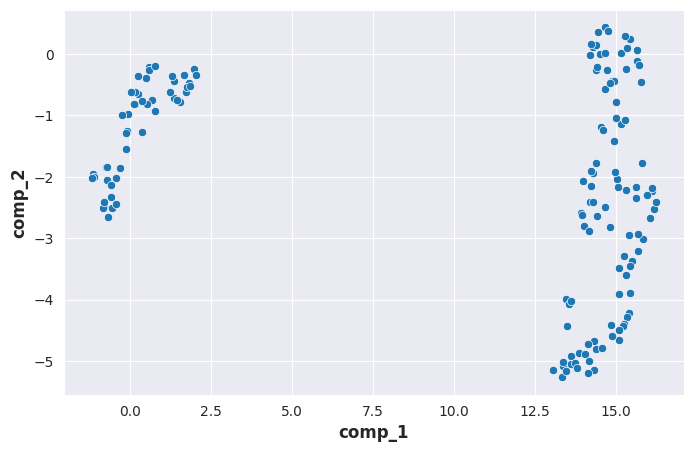

In [ ]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(data= X, x="comp_1", y="comp_2")
plt.show()

## Definition of plotting and convergence check function

In [ ]:
# function to visualize identified clusters

def visualize_clusters(*, df, labels_all, hyperparam_name, hyperparam_val, noise_exist):

    # Checking of input parameters omitted for this notebook

    labels = sorted(pd.Series(labels_all).unique())

    if noise_exist:

        outlier_perc = int(round(( (len(df) - sum(np.where(labels_all == -1, False, True))) / len(df) ) * 100, 0))

        plt.figure(figsize=std_figure_size)
        for label in labels:
            if label == -1:
                marker_style = "*"
            else:
                marker_style = "o"
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label), marker=marker_style)
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}; 'Noise': {outlier_perc}%")
        else:
            plt.title(f"Defaults for all hyperparameters; 'Noise': {outlier_perc}%")
        plt.legend(title="cluster ID")
        plt.show()

    else:

        plt.figure(figsize=std_figure_size)
        for label in labels:
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label))
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}")
        else:
            plt.title(f"Defaults for all hyperparameters")
        plt.legend(title="cluster ID")
        plt.show()


def convergence_check(model):
    """Checking if fitted model converged within the max. number of iterations."""
    if model.n_iter_ < model.max_iter:
        print(f"Algorithm converged successfully!\nn_iter: {model.n_iter_}, max_iter: {model.max_iter}\n")
    else:
        print(f"WARNING: Algorithm did not converge within {model.max_iter} iterations!\n")

## Algo 1: K-means

In [ ]:
# hyperparameter to tune

kmeans_hparam = "n_clusters"

### Identifying the "optimal" number of clusters

In [ ]:
inertias_1 = []
range_clusters_1 = np.arange(2, 10, dtype=int)

for n in range_clusters_1:
    kmeans_1 = KMeans(n_clusters=n, random_state=fixed_random_state).fit(X)
    inertias_1.append(kmeans_1.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

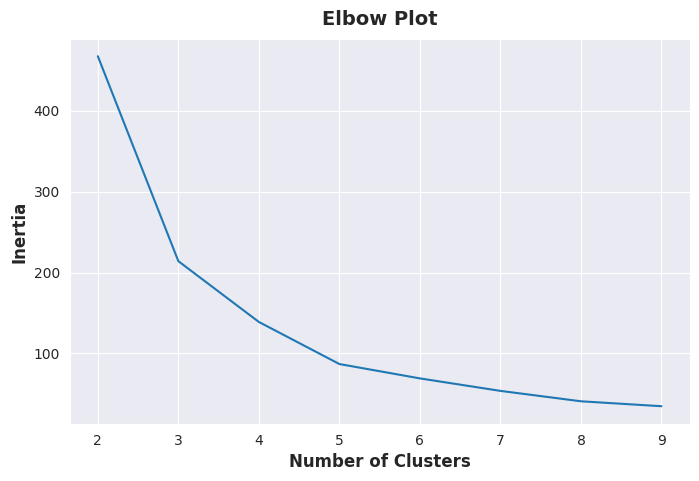

In [ ]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_1, y=inertias_1)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
%%time

start_time = time.time()

kmeans = KMeans(n_clusters=3, random_state=fixed_random_state)

labels_1 = kmeans.fit_predict(X)

convergence_check(kmeans)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 4, max_iter: 300

CPU times: user 36.5 ms, sys: 0 ns, total: 36.5 ms
Wall time: 25.4 ms


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


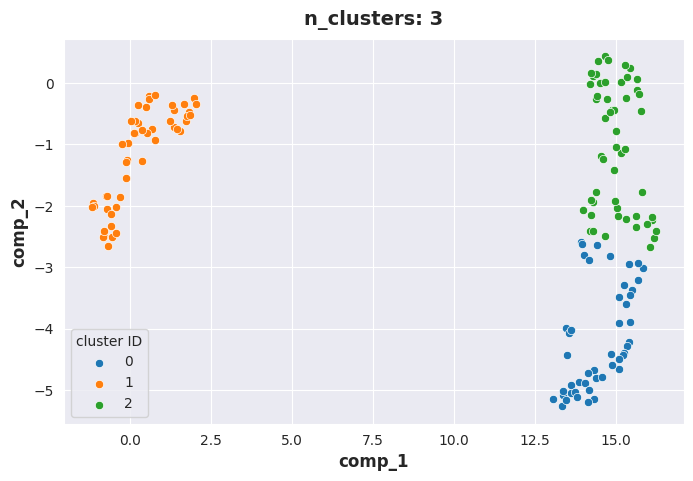

In [ ]:
visualize_clusters(df=X, labels_all=labels_1, hyperparam_name=kmeans_hparam, hyperparam_val=3, noise_exist=False)

## Algo 2: Mean shift

In [ ]:
# hyperparamter to tune

meanshift_hparam = "bandwidth"

In [ ]:
%%time

start_time = time.time()

meanshift = MeanShift(n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 13, max_iter: 300

CPU times: user 147 ms, sys: 2.92 ms, total: 150 ms
Wall time: 413 ms


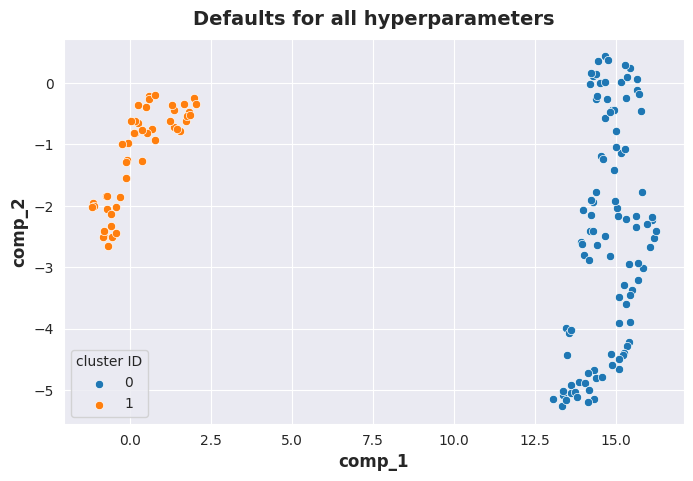

In [ ]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

### Allowing for 'noise'

In [ ]:
%%time

start_time = time.time()

meanshift = MeanShift(cluster_all=False, n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_time_meanshift_noise = time.time() - start_time

Algorithm converged successfully!
n_iter: 13, max_iter: 300

CPU times: user 206 ms, sys: 4.24 ms, total: 211 ms
Wall time: 809 ms


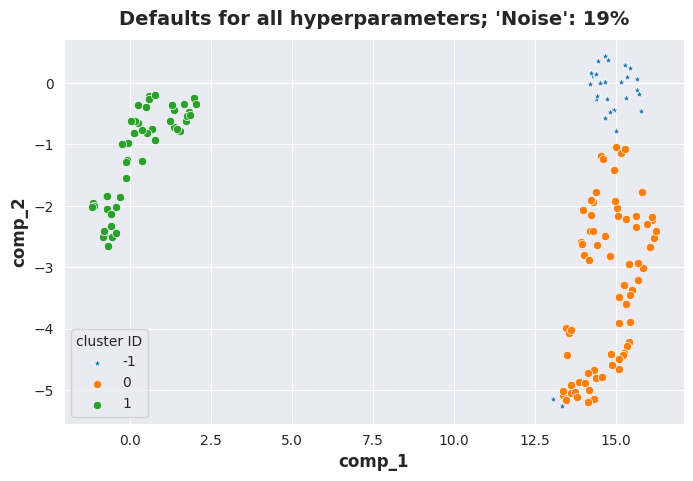

In [ ]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

## Algo 3: Gaussian Mixture

In [ ]:
# hyperparamter to tune

gmm_hparam = "n_components"

In [ ]:
%%time

start_time = time.time()

gmm = GaussianMixture(n_components=3, random_state=fixed_random_state)

labels_3 = gmm.fit_predict(X)

convergence_check(gmm)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 10, max_iter: 100

CPU times: user 25.3 ms, sys: 14.2 ms, total: 39.4 ms
Wall time: 41.2 ms


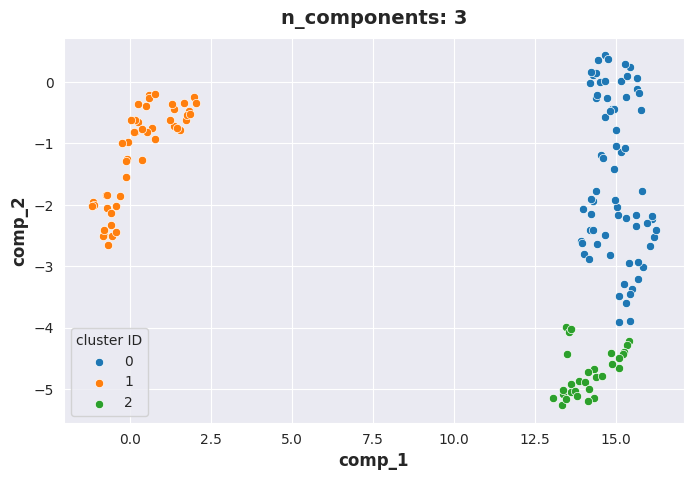

In [ ]:
visualize_clusters(df=X, labels_all=labels_3, hyperparam_name=gmm_hparam, hyperparam_val=3, noise_exist=False)

## Algo 4: Affinity propagation

In [ ]:
# hyperparamter to tune

affprop_hparam = "damping"

### Vanilla run (defaults for all hyperparameters)

In [ ]:
%%time

affprop = AffinityPropagation(random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)

Algorithm converged successfully!
n_iter: 32, max_iter: 200

CPU times: user 29.3 ms, sys: 0 ns, total: 29.3 ms
Wall time: 43.9 ms


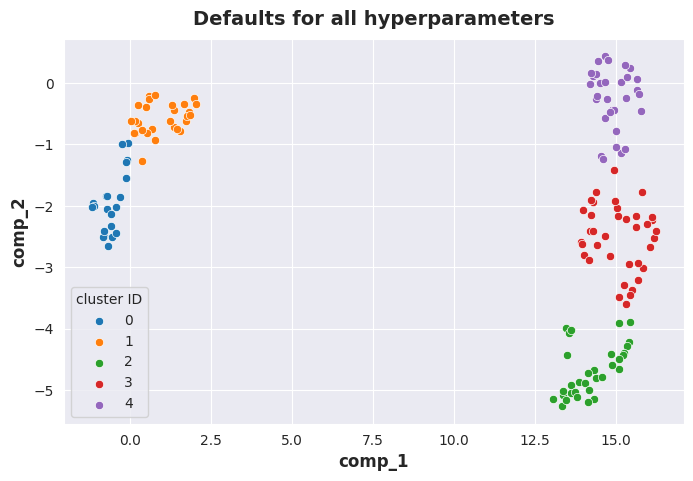

In [ ]:
visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

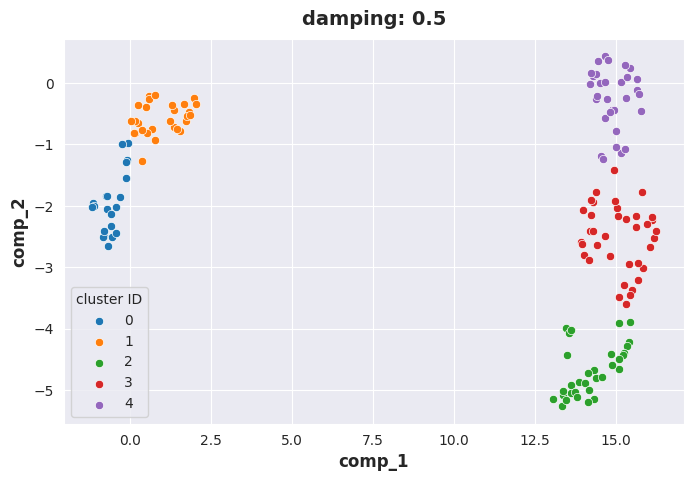

Algorithm converged successfully!
n_iter: 32, max_iter: 500



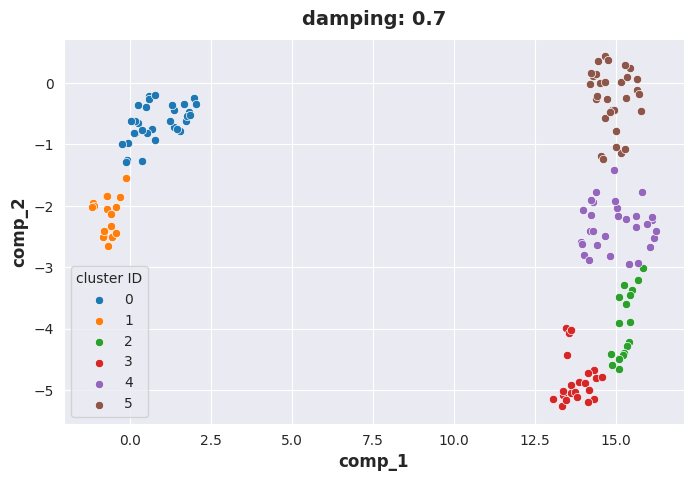

Algorithm converged successfully!
n_iter: 30, max_iter: 500



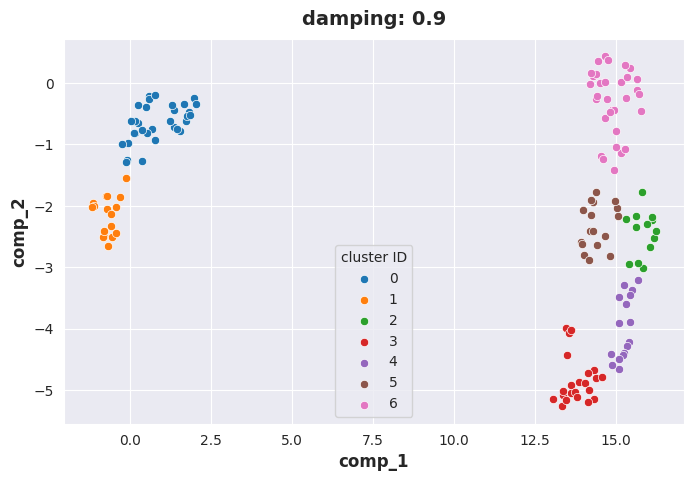

Algorithm converged successfully!
n_iter: 57, max_iter: 500



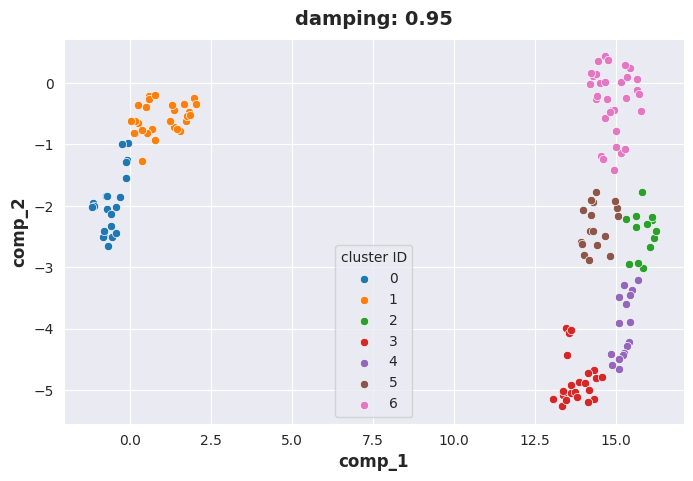

Algorithm converged successfully!
n_iter: 92, max_iter: 500



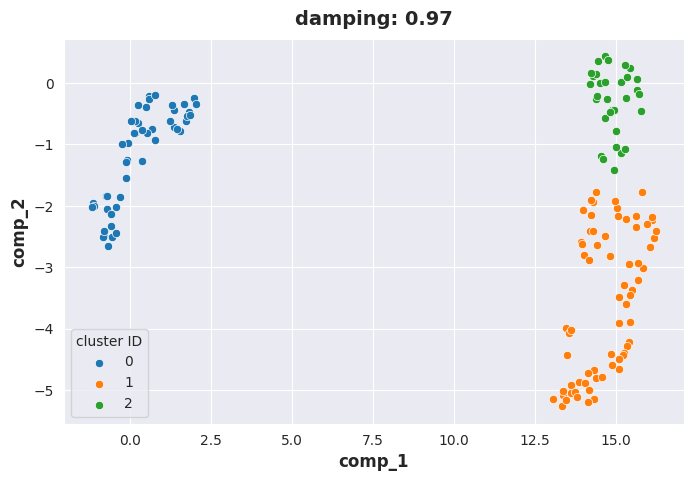

Algorithm converged successfully!
n_iter: 123, max_iter: 500



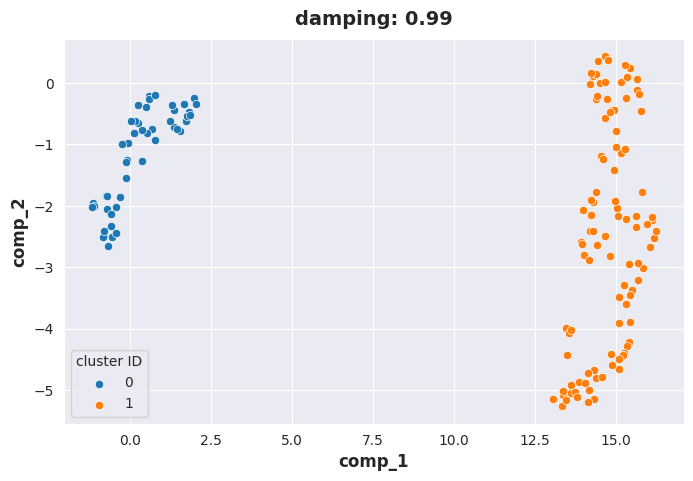

Algorithm converged successfully!
n_iter: 314, max_iter: 500

CPU times: user 5.67 s, sys: 279 ms, total: 5.95 s
Wall time: 10.4 s


In [ ]:
%%time

damps = [0.5, 0.7, 0.9, 0.95, 0.97, 0.99]

for d in damps:
    affprop = AffinityPropagation(damping=d, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=d, noise_exist=False)
    convergence_check(affprop)

### Tuning runs for "preference"

In [ ]:
# hyperparamter to tune

affprop_hparam = "preference"

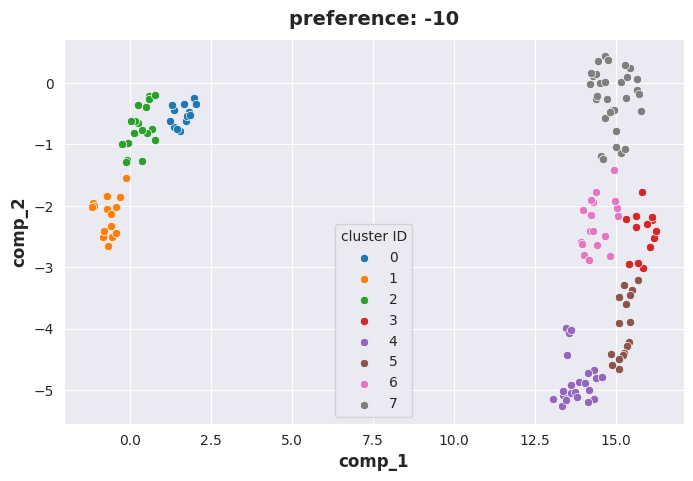

Algorithm converged successfully!
n_iter: 31, max_iter: 500



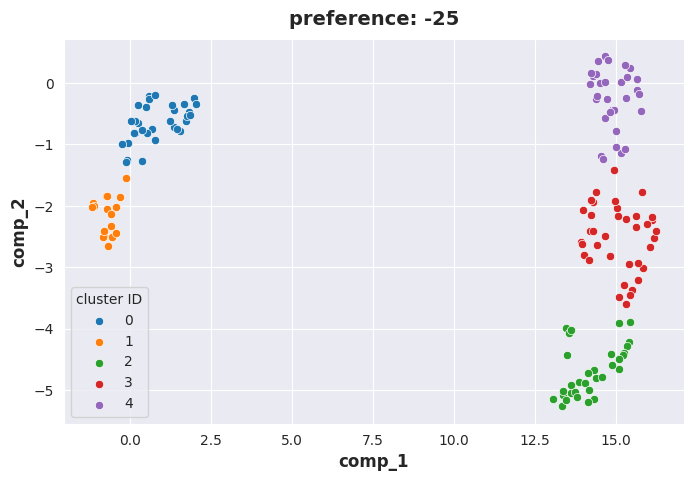

Algorithm converged successfully!
n_iter: 41, max_iter: 500



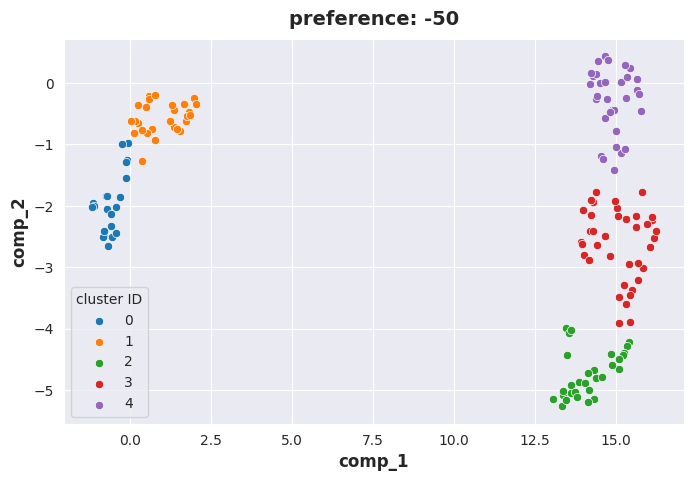

Algorithm converged successfully!
n_iter: 54, max_iter: 500



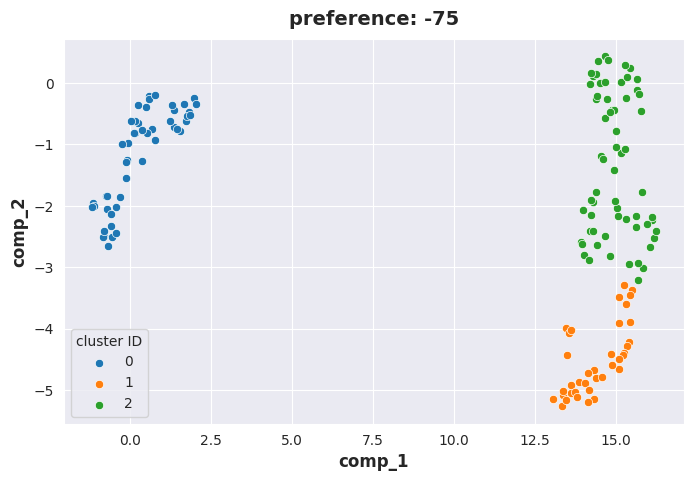

Algorithm converged successfully!
n_iter: 48, max_iter: 500



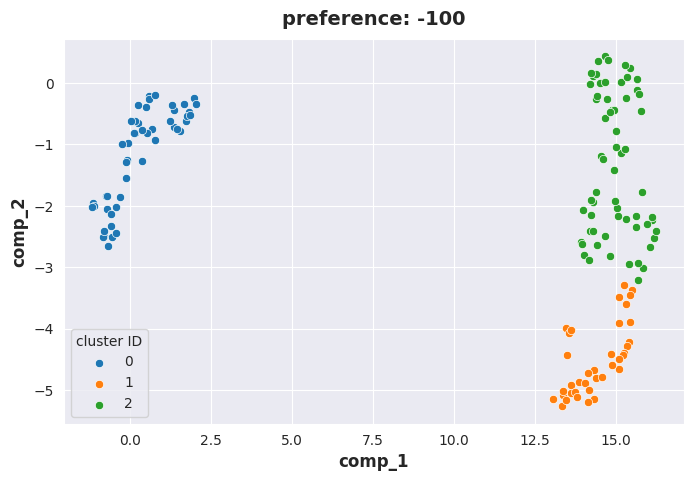

Algorithm converged successfully!
n_iter: 273, max_iter: 500

CPU times: user 4.46 s, sys: 295 ms, total: 4.76 s
Wall time: 6.74 s


In [ ]:
%%time

prefs = [-10, -25, -50, -75, -100]

for p in prefs:
    affprop = AffinityPropagation(preference=p, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=p, noise_exist=False)
    convergence_check(affprop)

### Re-run with optimised *preference*

In [ ]:
%%time

start_time = time.time()

affprop = AffinityPropagation(preference=-75, max_iter=500, random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 45, max_iter: 500

CPU times: user 36.9 ms, sys: 0 ns, total: 36.9 ms
Wall time: 90.6 ms


## Algo 5: DBSCAN

In [ ]:
# hyperparamter to tune

dbscan_hparam = "eps"

### Vanilla run (defaults for all hyperparameters)

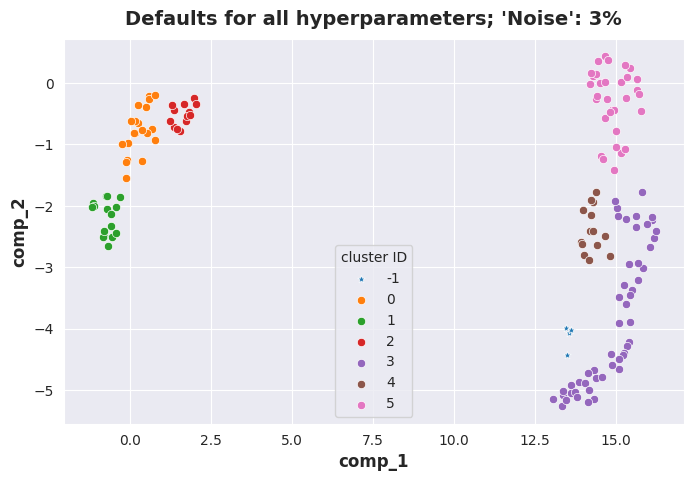

CPU times: user 1.05 s, sys: 41.7 ms, total: 1.09 s
Wall time: 3.27 s


In [ ]:
%%time

dbscan = DBSCAN(n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

### Tuning runs for *eps*

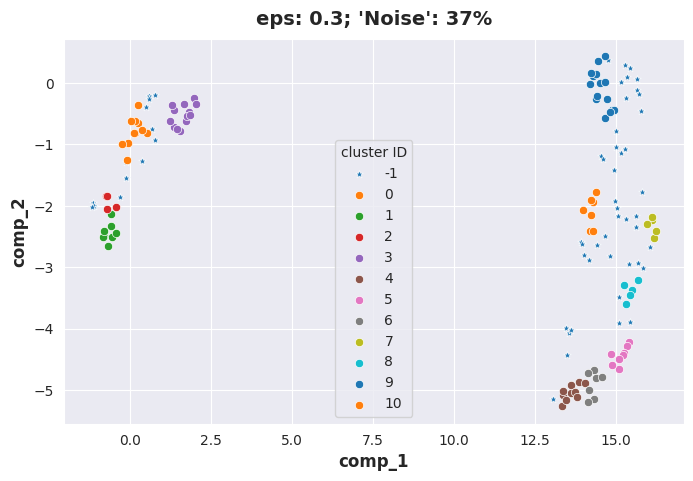

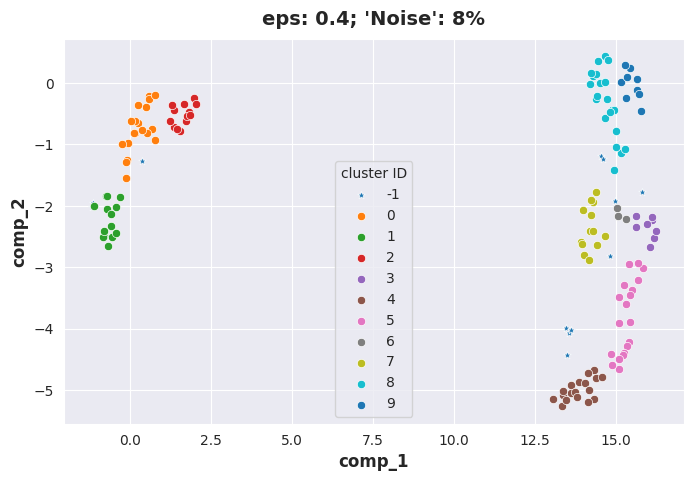

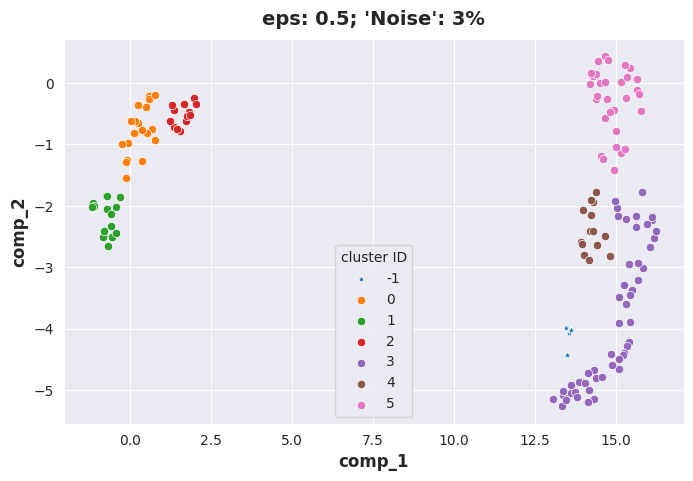

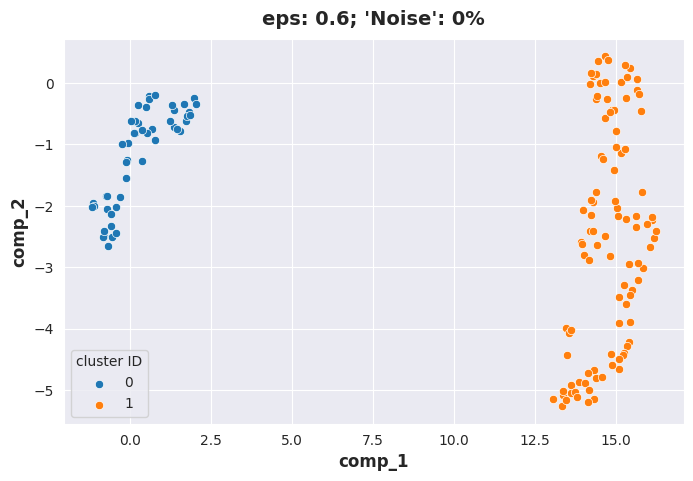

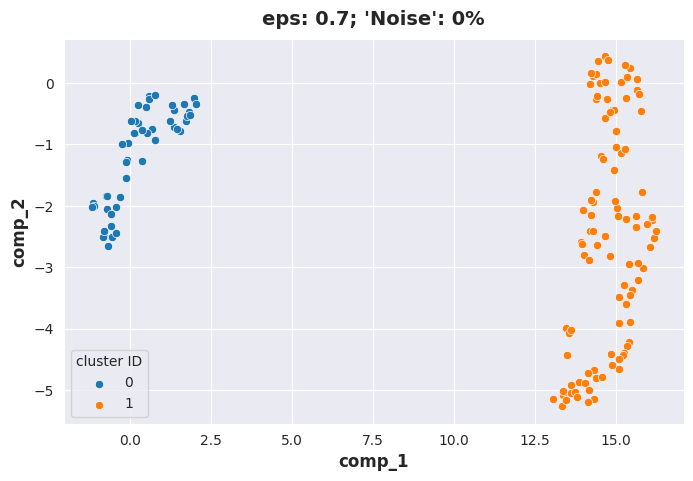

CPU times: user 5.05 s, sys: 281 ms, total: 5.33 s
Wall time: 9.19 s


In [ ]:
%%time

for e in [0.3, 0.4, 0.5, 0.6, 0.7]:

    dbscan = DBSCAN(eps=e, n_jobs=n_parallel_jobs)
    labels_5 = dbscan.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=dbscan_hparam, hyperparam_val=e, noise_exist=True)

### Re-run with optimised *eps*

In [ ]:
%%time

eps_val = 0.6

start_time = time.time()

dbscan = DBSCAN(eps=eps_val, n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: user 17.6 ms, sys: 955 µs, total: 18.5 ms
Wall time: 67.9 ms


## Algo 6: OPTICS

In [ ]:
# hyperparamter to tune

optics_hparam = "min_samples"

### Vanilla run (defaults for all hyperparameters)

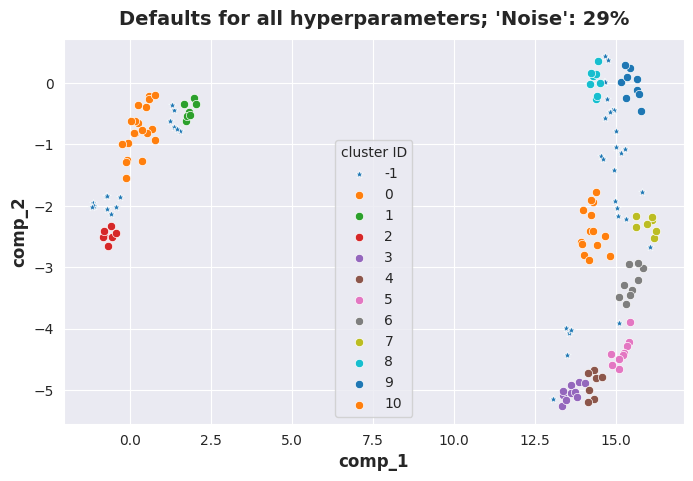

CPU times: user 2.28 s, sys: 173 ms, total: 2.45 s
Wall time: 7.51 s


In [ ]:
%%time

optics = OPTICS(n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

### Tuning runs for *min_samples*

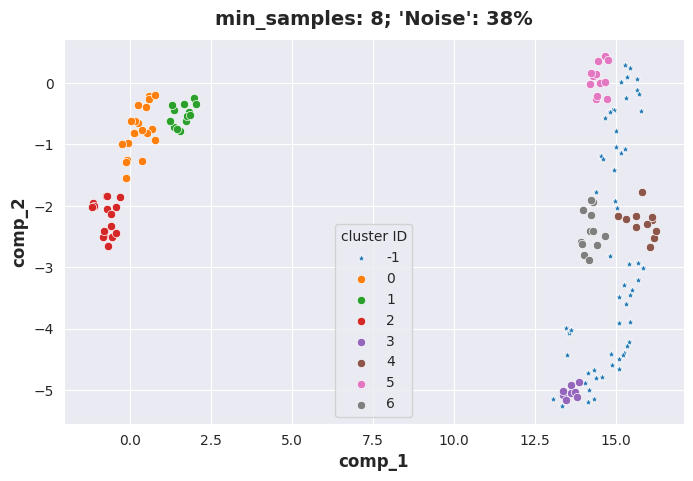

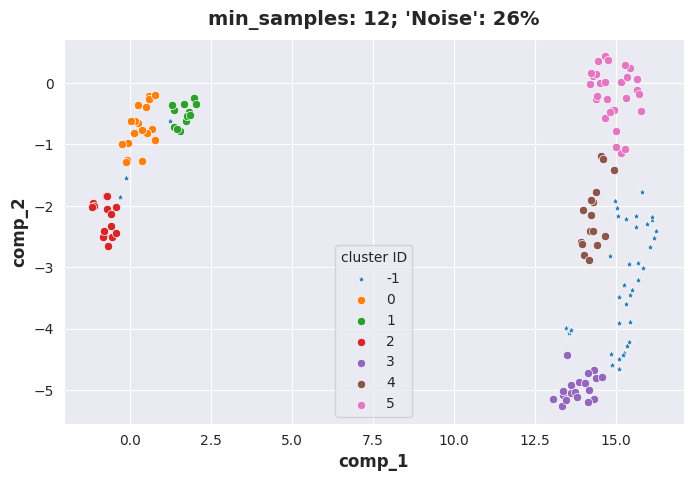

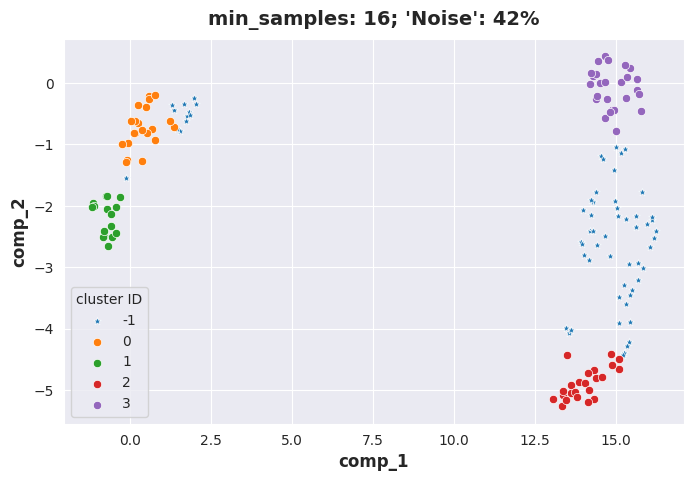

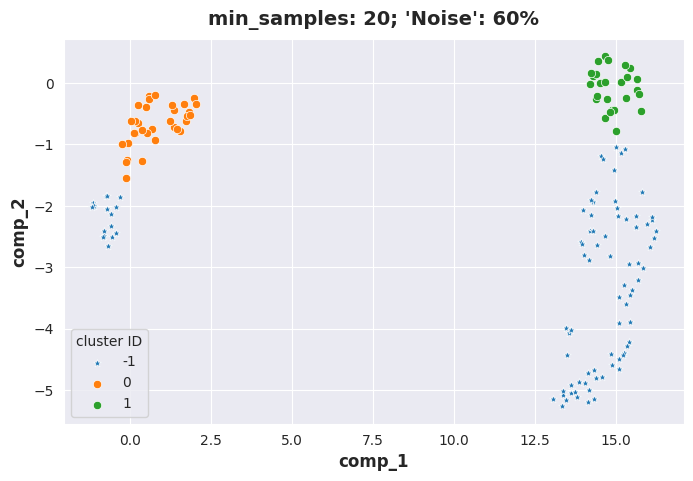

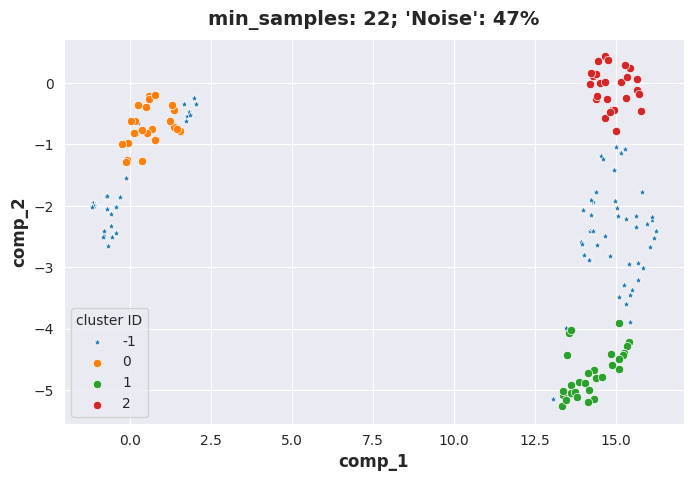

CPU times: user 6.08 s, sys: 1.14 s, total: 7.22 s
Wall time: 15.6 s


In [ ]:
%%time

for n_samples in [8, 12, 16, 20, 22]:

    optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

    labels_6 = optics.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=optics_hparam, hyperparam_val=n_samples, noise_exist=True)

### Re-run with optimised *min_samples*

In [ ]:
%%time

n_samples = 20

start_time = time.time()

optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: user 535 ms, sys: 126 ms, total: 661 ms
Wall time: 2.09 s


# Comparison of training times

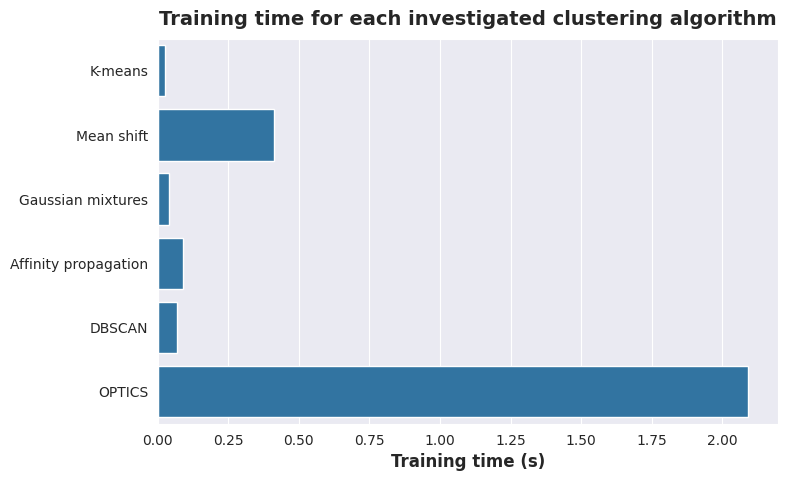

In [ ]:
plt.figure(figsize=std_figure_size)
sns.barplot(y=algoritmos, x=training_times)
plt.title("Training time for each investigated clustering algorithm")
plt.xlabel("Training time (s)")
plt.show()

In [ ]:
# overwriting the training time for Mean shift

training_times[1] = training_time_meanshift_noise

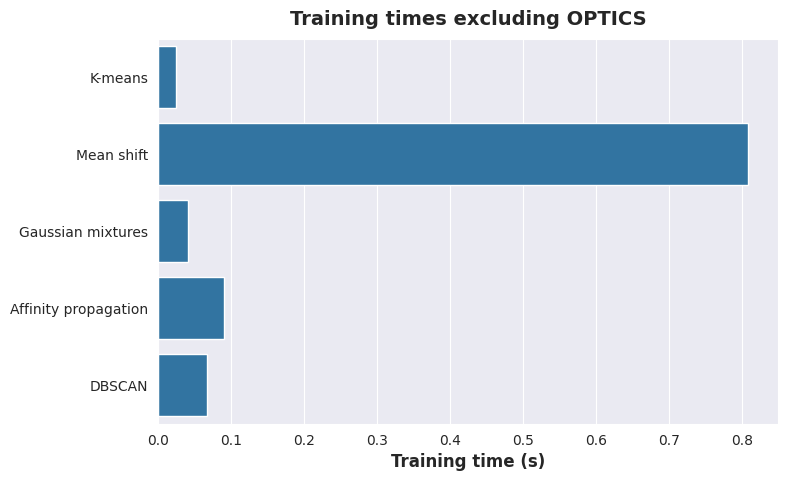

In [ ]:
plt.figure(figsize=std_figure_size)
sns.barplot(y=algoritmos[:-1], x=training_times[:-1])
plt.title("Training times excluding OPTICS")
plt.xlabel("Training time (s)")
plt.show()